In [1]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, UpSampling2D
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
!pip install tensorflow_addons

import json
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from segnet import SegNet
from sequence import FoodSequence
from crossentropy import MyCrossentropy

import random

     |████████████████████████████████| 686kB 12.2MB/s 


In [2]:
!pip install -U aicrowd-cli
API_KEY = "67587f4b3488144e75864045bf9db5e9" #get your api-key from https://www.aicrowd.com/participants/me

!aicrowd login --api-key $API_KEY 
!aicrowd dataset download --challenge food-recognition-challenge 3 4 5
!tar -zxvf train-v0.4.tar.gz

     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 215kB 20.7MB/s 
     |████████████████████████████████| 174kB 23.8MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


Streaming output truncated to the last 5000 lines.
./train/images/016635.jpg
./train/images/084765.jpg
./train/images/030078.jpg
./train/images/095272.jpg
./train/images/074596.jpg
./train/images/068251.jpg
./train/images/021057.jpg
./train/images/098101.jpg
./train/images/094285.jpg
./train/images/007293.jpg
./train/images/099408.jpg
./train/images/019538.jpg
./train/images/049791.jpg
./train/images/021889.jpg
./train/images/075978.jpg
./train/images/043050.jpg
./train/images/077428.jpg
./train/images/026325.jpg
./train/images/008192.jpg
./train/images/082412.jpg
./train/images/013239.jpg
./train/images/028513.jpg
./train/images/084736.jpg
./train/images/076279.jpg
./train/images/103474.jpg
./train/images/070743.jpg
./train/images/071644.jpg
./train/images/095290.jpg
./train/images/037048.jpg
./train/images/009347.jpg
./train/images/078783.jpg
./train/images/084642.jpg
./train/images/032499.jpg
./train/images/099724.jpg
./train/images/079743.jpg
./train/images/074193.jpg
./train/image

In [3]:
file = open("train/annotations.json", "r")
annotations = json.loads(file.read())

ann = pd.DataFrame(annotations['annotations'])
mapping = {item:i for i, item in enumerate(ann["category_id"].unique())}
ann["category_id"] = ann["category_id"].apply(lambda x: mapping[x])

annotations_map = {img_id: {} for img_id in ann['image_id'].unique()}
for index, row in ann.iterrows():
    annotations_map[row['image_id']][row['category_id']] = row['segmentation']

images = pd.DataFrame(annotations['images']).set_index('id')
categories = pd.DataFrame(annotations['categories'])
categories['id'] = categories['id'].apply(lambda x: mapping[x])
categories = categories.set_index('id')

In [4]:
def desired_output(img_shape, segmentations):
        desired_output = np.zeros((img_shape[0], img_shape[1], len(categories)), dtype=np.int32)

        for i in segmentations:
          t = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.int32)
          for seg in segmentations[i]:
              s = np.array(seg, dtype=np.int32).reshape((-1, 2))
              t = cv2.fillPoly(t, [s], 255)

          desired_output[:, :, i] = t.squeeze()

        return desired_output / 255

(629, 629, 3)
(629, 629, 273)


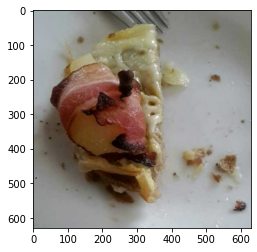

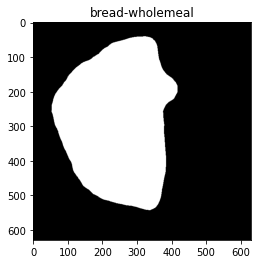

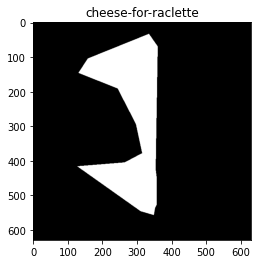

In [5]:
img_id = images.sample().index.values[0]

img_ann = ann[ann['image_id'] == img_id]
segmentations = dict(zip(img_ann['category_id'], img_ann['segmentation']))

img = cv2.imread('train/images/' + images.loc[img_id, 'file_name'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img);
print(img.shape)

desired_out = desired_output(img.shape, segmentations)
print(desired_out.shape)
for i in range(desired_out.shape[-1]):
    if np.any(desired_out[:, :, i] != 0):
        fig = plt.figure()
        plt.title(categories.iloc[i]['name'])
        plt.imshow(desired_out[:, :, i], cmap='gray');

In [6]:
dataset = FoodSequence(images, annotations_map, len(categories), img_size=(256, 256), batch_size=8)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/challenge/models/segnet/model139', custom_objects={"SegNet": SegNet}, compile=False)

In [9]:
classes_total_area = ann.groupby(by='category_id')['area'].sum()
category_weights = np.max(classes_total_area) / classes_total_area
category_weights = np.float32(category_weights)
beta = 100 

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss=MyCrossentropy(category_weights, beta=beta)
    )

In [11]:
history = model.fit(dataset)

3014/3014 [==============================] - 5889s 2s/step - loss: 0.1289


In [12]:
history.history

{'loss': [0.12891381978988647]}

In [13]:
model.save('/content/gdrive/MyDrive/challenge/models/segnet/model140')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/challenge/models/segnet/model140/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/challenge/models/segnet/model140/assets


In [14]:
val_file = open("val/annotations.json", "r")
val_annotations = json.loads(val_file.read())

val_ann = pd.DataFrame(val_annotations['annotations'])
val_ann["category_id"] = val_ann["category_id"].apply(lambda x: mapping[x])
val_annotations_map = {img_id: {} for img_id in val_ann['image_id'].unique()}
for index, row in val_ann.iterrows():
    val_annotations_map[row['image_id']][row['category_id']] = row['segmentation']
val_images = pd.DataFrame(val_annotations['images'])
val_images = val_images.set_index('id')

val_set = FoodSequence(val_images, val_annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)
model.evaluate(val_set)

1269/1269 [==============================] - 164s 128ms/step - loss: 0.1211


0.1210910901427269

loss:  tf.Tensor(0.06045596, shape=(), dtype=float32)
loss of zeros:  tf.Tensor(0.30505082, shape=(), dtype=float32)
There is a banana with max 0.67977726
There are 11 categories more likely than the true min


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


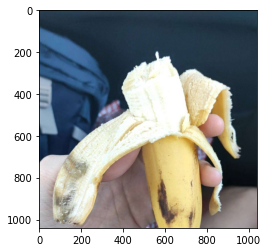

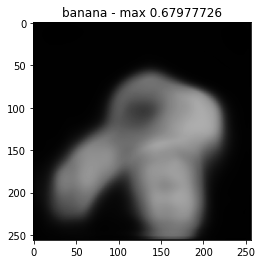

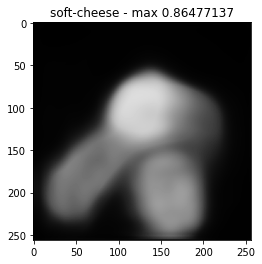

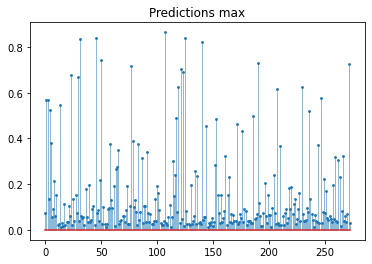

In [15]:
img_id = val_images.sample().index.values[0]
img = cv2.imread('val/images/' + val_images.loc[img_id, 'file_name'])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

input_img = cv2.resize(img, dsize=(256, 256)) / 255
y = model.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2])))

img_ann = val_ann[val_ann['image_id'] == img_id]
segmentations = dict(zip(img_ann['category_id'], img_ann['segmentation']))
y_true = desired_output(img.shape, segmentations)
y_true = cv2.resize(y_true, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
print("loss: ", MyCrossentropy(category_weights, beta=beta)(y_true, y))
print("loss of zeros: ", MyCrossentropy(category_weights, beta=beta)(y_true, np.zeros((1, 256, 256, 273), dtype=np.float32)))

min_of_seg = 1
for seg in segmentations:
  seg_max = np.max(y[0, :, :, seg])
  print("There is a", categories.iloc[seg]['name'], "with max", seg_max)
  if seg_max < min_of_seg:
    min_of_seg = seg_max

more_likely = [np.any(y[0, :, :, i] > min_of_seg) for i in range(len(categories))]
print("There are", np.count_nonzero(more_likely), "categories more likely than the true min")

for i in range(len(categories)):
  if np.any(y[0, :, :, i] >= np.max(y)) or i in segmentations:
    fig = plt.figure()
    plt.title(categories.iloc[i]['name'] + " - max " + str(np.max(y[0, :, :, i])))
    plt.imshow(y[0, :, :, i], cmap='gray', vmin=0, vmax=1)



fig = plt.figure();
markerline, stemline, baseline = plt.stem(range(273), np.max(y, axis=(0,1, 2)));
plt.setp(stemline, linewidth = 0.5);
plt.setp(markerline, markersize = 1.8);
plt.title('Predictions max');